
# StrategySV Optimization

Optimizing the Strategy Parameters for Algo-Strategy Forex.

Here's a quick TOC:

1. [Importing Forex Data](#importing-forex-data)
1. [Processing Data](#processing-data)
1. [Analyzing Parameters](#analyzing-parameters)
1. [Preparing Backtests](#preparing-backtests)
1. [Trading Assumptions](#trading-assumptions)
1. [Running Backtests](#running-backtets)
1. [Analyzing Backtest Results](#analyzing-backtest-results)
1. [Running Papertests](#running-papertests)
1. [Analyzing Papertest Results](#analyzing-papertest-results)
1. [Plotting Optimized Results](#plotting-optimized-results)

## Importing Forex Data


In [54]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

forex_symbol = "NZDUSD"

forex_df = pd.read_csv('../../data/gen/{}_Daily_df.csv'.format(forex_symbol),
                       parse_dates=True,
                       index_col=0)
# Strip whitespace from column names
forex_df.columns = forex_df.columns.str.strip()
# Print
forex_df.head()


,timestamp,open,high,low,close,pre_close,p_change,pip_change
4998,2001-07-30,0.4119,0.4140,0.4104,0.4120,0.4116,0.000972,9.718173
4997,2001-07-31,0.4120,0.4130,0.4090,0.4121,0.4120,0.000243,2.427184
4996,2001-08-01,0.4122,0.4189,0.4104,0.4184,0.4121,0.015288,152.875516
4995,2001-08-02,0.4182,0.4191,0.4158,0.4182,0.4184,-0.000478,-4.780115
4994,2001-08-03,0.4182,0.4224,0.4154,0.4181,0.4182,-0.000239,-2.391200



## Processing Data

In order to run StrategySV, we need to calculate `slope` and `velocity` data.

Due to `numpy.gradient` calculation, we need to use `pre_pre_close` to calculate slope, to make sure it does not use current period's data, as it's unknown.


In [55]:

extra_df = forex_df.copy()
extra_df['pre_pre_close'] = extra_df.pre_close.shift(1) 
extra_df = extra_df.iloc[1:]
extra_df['slope'] = pd.Series(np.gradient(extra_df.pre_pre_close), extra_df.index, name='slope')
extra_df['velocity'] = pd.Series(np.gradient(extra_df.slope), extra_df.index, name='velocity')
# Print
extra_df.head()


,timestamp,open,high,low,close,pre_close,p_change,pip_change,pre_pre_close,slope,velocity
4997,2001-07-31,0.4120,0.4130,0.4090,0.4121,0.4120,0.000243,2.427184,0.4116,0.00040,-0.000150
4996,2001-08-01,0.4122,0.4189,0.4104,0.4184,0.4121,0.015288,152.875516,0.4120,0.00025,0.001400
4995,2001-08-02,0.4182,0.4191,0.4158,0.4182,0.4184,-0.000478,-4.780115,0.4121,0.00320,0.001400
4994,2001-08-03,0.4182,0.4224,0.4154,0.4181,0.4182,-0.000239,-2.391200,0.4184,0.00305,-0.001675
4993,2001-08-06,0.4172,0.4198,0.4158,0.4189,0.4181,0.001913,19.134178,0.4182,-0.00015,-0.001350



## Analyzing Parameters

To determine sensible slop & velocity range to run backtests on, slope & velocity needs to be analysed.


DescribeResult(nobs=4998, minmax=(-0.02899999999999997, 0.023249999999999993), mean=4.771908763505403e-05, variance=1.3907759455192923e-05, skewness=-0.44563802026264193, kurtosis=2.983404361004877)

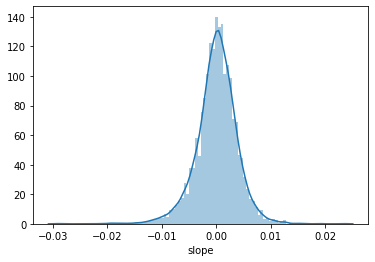

In [56]:

import seaborn as sns
from scipy import stats

sns.distplot(extra_df['slope'],
             bins=100,
             label="Daily Slope Change")
stats.describe(extra_df.slope)


DescribeResult(nobs=4998, minmax=(-0.013524999999999981, 0.02612499999999998), mean=-1.0004001600625271e-08, variance=7.039894186411805e-06, skewness=0.19691716733272524, kurtosis=3.4518279949669566)

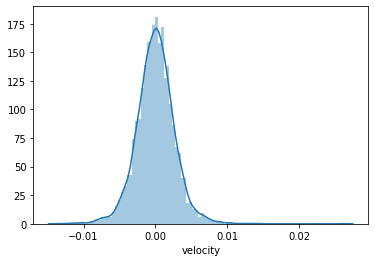

In [57]:

sns.distplot(extra_df['velocity'],
             bins=100,
             label="Daily Velocity Change")
stats.describe(extra_df.velocity)



## Preparing Backtests

Now we understand `slope` and `velocity` parameters, let's prepare parameters for backtesting.


In [58]:

import itertools

buy_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
buy_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)
close_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
close_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)
sell_slope_threshold_list = np.arange(extra_df.slope.mean() - extra_df.slope.std(), extra_df.slope.mean() + extra_df.slope.std(), extra_df.slope.std() * 2 / 5)
sell_velocity_threshold_list = np.arange(extra_df.velocity.mean() - extra_df.velocity.std(), extra_df.velocity.mean() + extra_df.velocity.std(), extra_df.velocity.std() * 2 / 5)

task_list = list(itertools.product(
    buy_slope_threshold_list, 
    buy_velocity_threshold_list, 
    close_slope_threshold_list, 
    close_velocity_threshold_list, 
    sell_slope_threshold_list, 
    sell_velocity_threshold_list
))
print("Backtest Params Ready, {} tasks to run. Will take about {} minutes to complete.".format(len(task_list), round(len(task_list)/(200*60), 2)))


Backtest Params Ready, 15625 tasks to run. Will take about 1.3 minutes to complete.



## Trading Assumptions

Forex is usually traded in **lots**, with **leverage**. 

To understand Forex Trading, here's a quick [Forex 101](./forex-math.md).   

Before we start the backtests, let's establish some assumptions.


In [59]:

lots = 1 # Trading Size 
leverage = 400 # 400 Leverage
margin_interest = 0.1 # 10% Margin Interest
pip_cost = 0.8 # Transaction Cost 0.8 pip
stop_loss = 2.0 # Stop Loss at 2.0 of standard deviation (so 5%)
one_trade_week = 6 # 6 Trade days a week for Forex
one_trade_month = one_trade_week * 4
two_trade_month = one_trade_month * 2
three_trade_month = one_trade_month * 3
half_trade_year = three_trade_month * 2
one_trade_year = half_trade_year * 2



## Running Backtests


In [60]:

import concurrent.futures
from concurrent.futures.process import ProcessPoolExecutor
from datetime import datetime
from tqdm import tqdm

backtest_df = forex_df[:-one_trade_year] # We use all available data until 2 years ago
    
# Defining a DataFrame to handle results
backtest_result = pd.DataFrame(columns=['buy_slope_threshold', 'buy_velocity_threshold', 'close_slope_threshold', 'close_velocity_threshold', 'sell_slope_threshold', 'sell_velocity_threshold', 'profit_percentage'])

def single_test(data_df, 
                t_lots,
                t_leverage,
                t_pip_cost,
                buy_slope_threshold, 
                buy_velocity_threshold, 
                close_slope_threshold, 
                close_velocity_threshold, 
                sell_slope_threshold, 
                sell_velocity_threshold):
            
        """
        Firstly, add `slope` and `velocity` columns to DataFrame
        """
        data_df['profit'] = 0
        data_df['slope'] = pd.Series(np.gradient(data_df.pre_close), data_df.index, name='slope') # Find the slope of yesterday, aka. pre_close
        data_df['velocity'] = pd.Series(np.gradient(data_df.slope), data_df.index, name='velocity')
        
        """
        Secondly, Closing
        """
        data_df['position'] = "CLOSE"
        
        """
        Thirdly, Buying
        """
        long_mask = (data_df.slope > buy_slope_threshold) & (data_df.velocity > buy_velocity_threshold)
        long_close = (data_df.slope < -close_slope_threshold) & (data_df.velocity < -close_velocity_threshold)
        data_df.loc[long_mask, 'position'] = "LONG"
        data_df.loc[long_mask, 'profit'] = (data_df.loc[long_mask, 'pip_change'] - t_pip_cost * 2) * t_lots * 10 # Assuming 2 transaction pip cost for buying and selling.
        # if stop_loss != 0:
            # TODO: Implement Stop Loss.
        
        """
        Finally, Selling
        """
        short_mask = (data_df.slope < sell_slope_threshold) & (data_df.velocity < sell_velocity_threshold)
        short_close = (data_df.slope > close_slope_threshold) & (data_df.velocity > close_velocity_threshold)
        data_df.loc[short_mask, 'position'] = "SHORT"
        data_df.loc[short_mask, 'profit'] = -(data_df.loc[short_mask, 'pip_change'] + t_pip_cost * 2) * t_lots * 10 # Assuming 2 transaction pip cost for buying and selling.
        # if stop_loss != 0:
            # TODO: Implement Stop Loss.
    
        test_result = [buy_slope_threshold, 
                       buy_velocity_threshold, 
                       close_slope_threshold, 
                       close_velocity_threshold, 
                       sell_slope_threshold, 
                       sell_velocity_threshold, 
                       data_df.profit.sum() / (lots * 100000 / t_leverage)]
        return test_result

start_time = datetime.now()

with ProcessPoolExecutor() as executor:
    """
    By default, ProcessPool uses maximum available number of cores to process.
    """
    
    """
    Equivalent to executor.map(fn, *iterables),
    but displays a tqdm-based progress bar.
    
    Does not support timeout or chunksize as executor.submit is used internally
    
    **kwargs is passed to tqdm.
    """
    futures_list = []
    kwargs = {
        'total': len(futures_list),
        'mininterval': 30.0,
        'unit': 'tests',
        'unit_scale': True,
        'leave': True
    }
        
    futures_list = [executor.submit(single_test, 
                                    backtest_df,
                                    lots,
                                    leverage,
                                    pip_cost,
                                    buy_slope_threshold, 
                                    buy_velocity_threshold, 
                                    close_slope_threshold, 
                                    close_velocity_threshold, 
                                    sell_slope_threshold, 
                                    sell_velocity_threshold) for buy_slope_threshold, \
                                                                 buy_velocity_threshold, \
                                                                 close_slope_threshold, \
                                                                 close_velocity_threshold, \
                                                                 sell_slope_threshold, \
                                                                 sell_velocity_threshold in task_list]
    print("Running {} tasks".format(len(futures_list)))
    
    for f in tqdm(concurrent.futures.as_completed(futures_list), **kwargs):
        # done_callback runs on the main process
        result_row = f.result()
        
        backtest_result = backtest_result.append(pd.Series(result_row, index=backtest_result.columns), ignore_index=True)

    print("Finished {} tasks in {}".format(len(task_list), datetime.now() - start_time))


15.6ktests [01:15, 207tests/s]


Running 15625 tasks
Finished 15625 tasks in 0:01:16.440036



## Analyzing Backtest Results


DescribeResult(nobs=15625, minmax=(2302.69408628848, 7878.972438401617), mean=5417.233916674853, variance=1256799.2651322274, skewness=-0.015961269918634512, kurtosis=-0.5184029333605507)


,buy_slope_threshold,buy_velocity_threshold,close_slope_threshold,close_velocity_threshold,sell_slope_threshold,sell_velocity_threshold,profit_percentage
619,-0.003682,-0.002653,0.002285,0.001592,0.000794,0.001592,7878.972438
168,-0.003682,-0.002653,-0.002190,-0.001592,0.000794,0.001592,7878.972438
469,-0.003682,-0.002653,0.000794,0.000531,0.000794,0.001592,7878.972438
443,-0.003682,-0.002653,0.000794,-0.000531,0.000794,0.001592,7878.972438
268,-0.003682,-0.002653,-0.000698,-0.002653,0.000794,0.001592,7878.972438


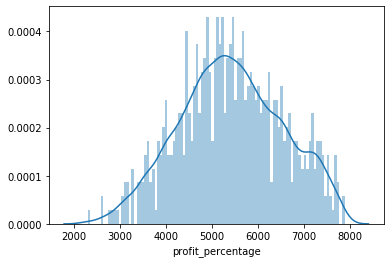

In [61]:
        
backtest_result = backtest_result.sort_values(by=['profit_percentage'],
                                        ascending=False)
backtest_result.to_csv('../gen/StrategySV_{}_Daily_Backtest_Params_df.csv'.format(forex_symbol))

sns.distplot(backtest_result['profit_percentage'],
             bins=100,
             label="Backtest Results")
print(stats.describe(backtest_result.profit_percentage))

backtest_result.head()



## Running Papertests

Now we have the optimized parameters, let's run the papertests (forwardtests).


In [62]:

backtest_result = pd.read_csv('../gen/StrategySV_{}_Daily_Backtest_Params_df.csv'.format(forex_symbol))

paper_df = forex_df[-one_trade_year:] # We use all available data until year ago
paper_params = backtest_result.iloc[:5000] # We will papertest the profit generated by best 5,000 sets of parameters

paper_list = list(zip(paper_params.buy_slope_threshold, 
                     paper_params.buy_velocity_threshold,
                     paper_params.close_slope_threshold, 
                     paper_params.close_velocity_threshold,
                     paper_params.sell_slope_threshold, 
                     paper_params.sell_velocity_threshold,))


print("Papertest Params Ready, {} tasks to run. Will take about {} minutes to complete.".format(len(paper_list), round(len(paper_list)/(200*60), 2)))
    

Papertest Params Ready, 5000 tasks to run. Will take about 0.42 minutes to complete.


In [63]:
# Defining a DataFrame to handle results
paper_result = pd.DataFrame(columns=['buy_slope_threshold', 'buy_velocity_threshold', 'close_slope_threshold', 'close_velocity_threshold', 'sell_slope_threshold', 'sell_velocity_threshold', 'profit_percentage'])

start_time = datetime.now()

with ProcessPoolExecutor() as executor:
    """
    By default, ProcessPool uses maximum available number of cores to process.
    """
    
    """
    Equivalent to executor.map(fn, *iterables),
    but displays a tqdm-based progress bar.
    
    Does not support timeout or chunksize as executor.submit is used internally
    
    **kwargs is passed to tqdm.
    """
    futures_list = []
    kwargs = {
        'total': len(futures_list),
        'mininterval': 30.0,
        'unit': 'tests',
        'unit_scale': True,
        'leave': True
    }
        
    futures_list = [executor.submit(single_test, 
                                    paper_df,
                                    lots,
                                    leverage,
                                    pip_cost,
                                    buy_slope_threshold, 
                                    buy_velocity_threshold, 
                                    close_slope_threshold, 
                                    close_velocity_threshold, 
                                    sell_slope_threshold, 
                                    sell_velocity_threshold) for buy_slope_threshold, \
                                                                 buy_velocity_threshold, \
                                                                 close_slope_threshold, \
                                                                 close_velocity_threshold, \
                                                                 sell_slope_threshold, \
                                                                 sell_velocity_threshold in paper_list]
    print("Running {} tests".format(len(futures_list)))
    
    for f in tqdm(concurrent.futures.as_completed(futures_list), **kwargs):
        # done_callback runs on the main process
        result_row = f.result()
        
        paper_result = paper_result.append(pd.Series(result_row, index=paper_result.columns), ignore_index=True)

    print("Finished {} tests in {}".format(len(paper_list), datetime.now() - start_time))


5.00ktests [00:21, 228tests/s]


Running 5000 tests
Finished 5000 tests in 0:00:22.105330



## Analyzing Papertest Results


DescribeResult(nobs=5000, minmax=(144.68220704914214, 309.4243973102406), mean=236.20876648622482, variance=1111.4853864400823, skewness=0.1654959603904862, kurtosis=-0.5767181621909705)


,buy_slope_threshold,buy_velocity_threshold,close_slope_threshold,close_velocity_threshold,sell_slope_threshold,sell_velocity_threshold,profit_percentage
0,-0.003682,-0.002653,0.002285,0.001592,0.000794,0.001592,306.297656
1,-0.003682,-0.002653,-0.002190,-0.001592,0.000794,0.001592,306.297656
2,-0.003682,-0.002653,0.000794,0.000531,0.000794,0.001592,306.297656
3,-0.003682,-0.002653,0.000794,-0.000531,0.000794,0.001592,306.297656
4,-0.003682,-0.002653,-0.000698,-0.002653,0.000794,0.001592,306.297656


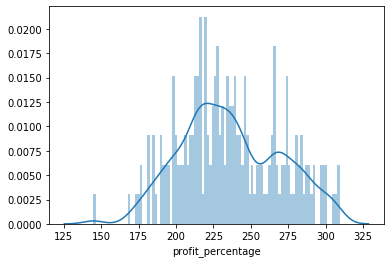

In [64]:

paper_result.to_csv('../gen/StrategySV_{}_Daily_PaperTest_Params_df.csv'.format(forex_symbol))

sns.distplot(paper_result['profit_percentage'],
             bins=100,
             label="Papertest Results")
print(stats.describe(paper_result.profit_percentage))

paper_result.head()



## Plotting Optimized Results

Plot the algo-trading results.


Plotting 288 results for trade days
LONG 2018-08-12 - 2018-08-13
SHORT 2018-08-13 - 2018-08-16
LONG 2018-08-16 - 2018-08-20
SHORT 2018-08-20 - 2018-08-21
LONG 2018-08-21 - 2018-08-22
CLOSE 2018-08-23
SHORT 2018-08-23 - 2018-08-24
LONG 2018-08-24 - 2018-08-27
SHORT 2018-08-27 - 2018-09-02
LONG 2018-09-02 - 2018-09-03
SHORT 2018-09-03 - 2018-09-05
LONG 2018-09-05 - 2018-09-07
SHORT 2018-09-07 - 2018-09-12
LONG 2018-09-12 - 2018-09-14
SHORT 2018-09-14 - 2018-09-17
LONG 2018-09-17 - 2018-09-22
SHORT 2018-09-22 - 2018-09-25
LONG 2018-09-25 - 2018-09-27
SHORT 2018-09-27 - 2018-09-30
LONG 2018-09-30 - 2018-10-01
SHORT 2018-10-01 - 2018-10-05
LONG 2018-10-05 - 2018-10-07
SHORT 2018-10-07 - 2018-10-09
LONG 2018-10-09 - 2018-10-10
SHORT 2018-10-10 - 2018-10-11
LONG 2018-10-11 - 2018-10-14
SHORT 2018-10-14 - 2018-10-15
LONG 2018-10-15 - 2018-10-16
CLOSE 2018-10-17
SHORT 2018-10-17 - 2018-10-18
LONG 2018-10-18 - 2018-10-22
SHORT 2018-10-22 - 2018-10-30
LONG 2018-10-30 - 2018-10-31
SHORT 2018-10-31

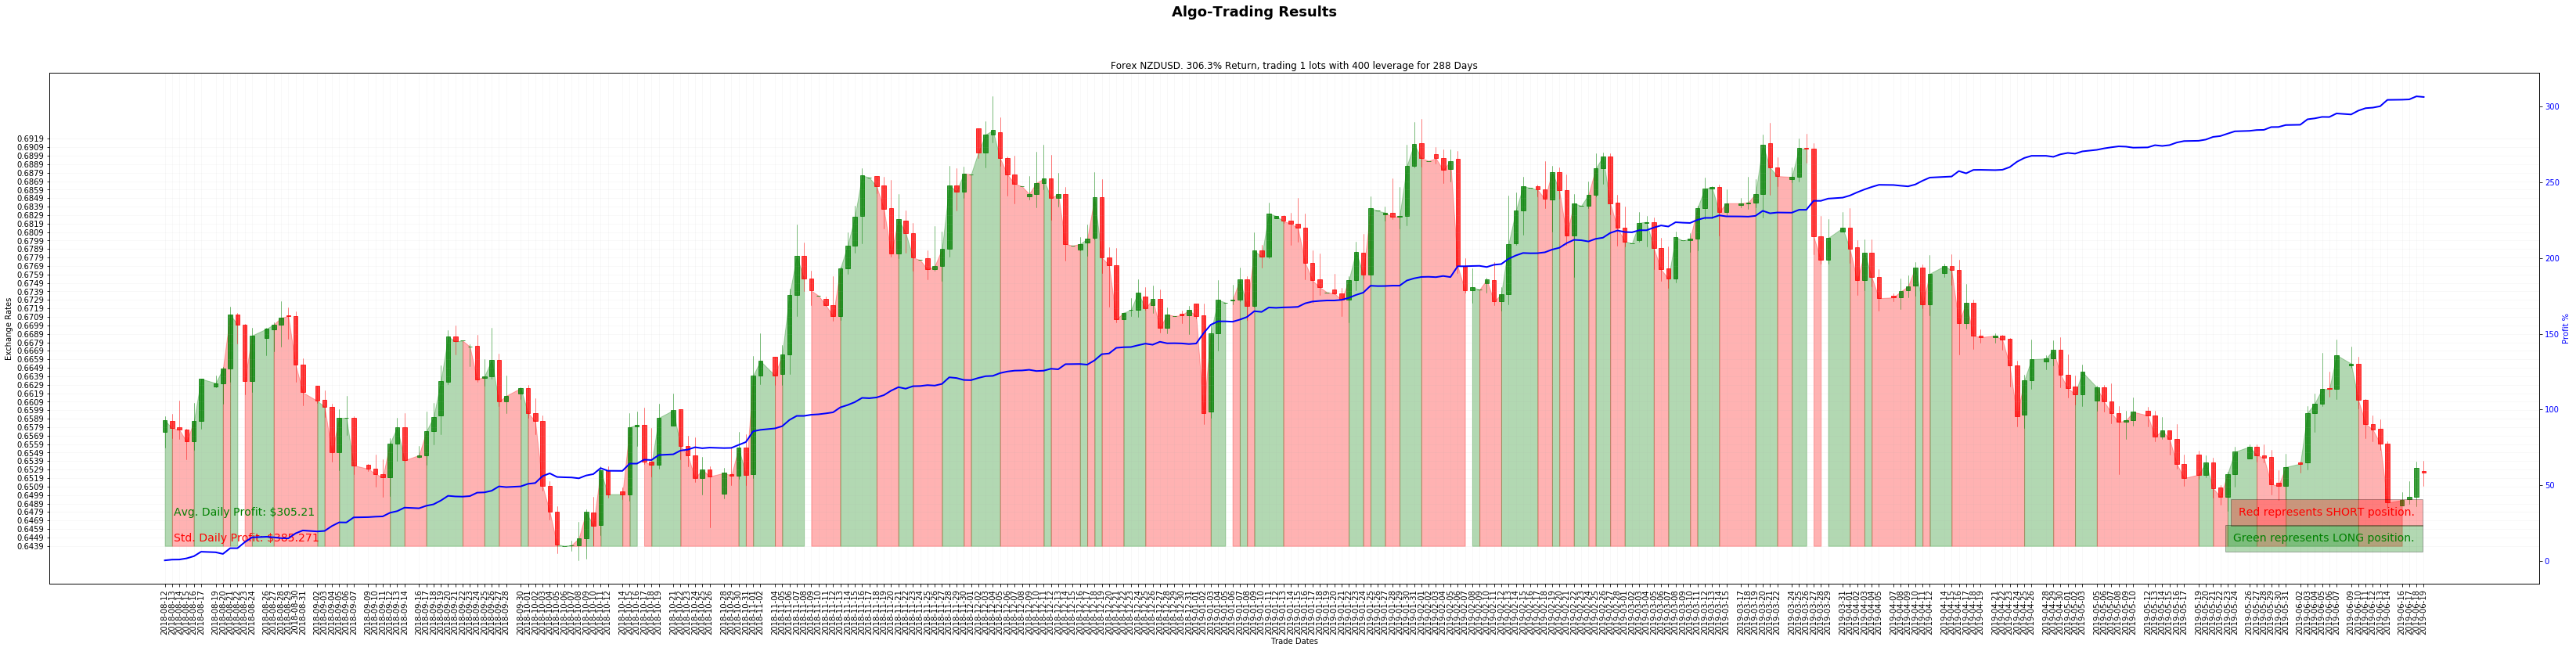

In [65]:

import import_ipynb
from strategy_sv import TradeStrategySV

paper_result = pd.read_csv('../gen/StrategySV_{}_Daily_PaperTest_Params_df.csv'.format(forex_symbol))
paper_result = paper_result.sort_values(by=['profit_percentage'],
                                        ascending=False)

fig, axs = plt.subplots(figsize = (int(len(paper_df.index)/5),12))

fig.suptitle('Algo-Trading Results', fontsize=18, fontweight='bold')

best_strategy = TradeStrategySV(leverage=leverage,
                               margin=margin_interest,
                               pip_cost=pip_cost,
                               buy_slope_threshold=paper_result.buy_slope_threshold[1], 
                               buy_velocity_threshold=paper_result.buy_velocity_threshold[1], 
                               close_slope_threshold=paper_result.close_slope_threshold[1], 
                               close_velocity_threshold=paper_result.close_velocity_threshold[1], 
                               sell_slope_threshold=paper_result.sell_slope_threshold[1], 
                               sell_velocity_threshold=paper_result.sell_velocity_threshold[1], 
                               should_log=True)
forex_df = best_strategy.trade(data_df=paper_df, 
                              symbol=forex_symbol,
                              lots=lots,
                              stop_loss=stop_loss,)



best_strategy.plot_trade(axs=axs)

fig.savefig('../gen/StrategySV_{}_Daily.png'.format(forex_symbol), dpi=150, bbox_inches="tight")

print("In the latest {} trading days, StrategySV (Optimized) resulted ${}, or {}%".format(len(paper_df.index), round(best_strategy.trade_profit, 2), round(best_strategy.trade_profit/(lots * 100000 / leverage), 2)))
